# Adaption for ALTI+ on BART model from MUSS

Original project and models: https://github.com/facebookresearch/muss

In [2]:
%load_ext autoreload
%autoreload 2

import os
import torch
# Select GPU
# torch.cuda.set_device(4)
# torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.interactive import *
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
# from wrappers.multilingual_transformer_wrapper import FairseqMultilingualTransformerHub
from wrappers.bart_wrapper import FairseqBartTransformerHub

# from fairseq.data.multilingual.multilingual_utils import (
#     EncoderLangtok,
#     LangTokSpec,
#     LangTokStyle,
#     augment_dictionary,
#     get_lang_tok,
# )

import alignment.align as align

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')
warnings.simplefilter('ignore')

# from dotenv import load_dotenv
# load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

# for bart
# from utils import read_lines, construct_multi_label_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load model

In [3]:
ckpt_dir = '/scratch/tkew/ctrl_tokens/resources/models/muss_en_mined'
checkpoint_file = 'model.pt'
data_name_or_path = '.'

hub = FairseqBartTransformerHub.from_pretrained(
    ckpt_dir,
    checkpoint_file=checkpoint_file,
    data_name_or_path=data_name_or_path,
    source_lang='complex',
    target_lang='simple',
)



In [4]:
# sentences = read_lines('/net/cephfs/scratch/tkew/ctrl_tokens/resources/data/examples.en')[:1]
# sentences, labels = construct_multi_label_dataset(sentences)
# # print(len(sentences))
# print(sentences[0])

100%|██████████| 1/1 [00:00<00:00, 25.69it/s]

*** Constructed 625 inputs ***
<DEPENDENCYTREEDEPTHRATIO_0.25> <WORDRANKRATIO_0.25> <REPLACEONLYLEVENSHTEIN_0.25> <LENGTHRATIO_0.25> This is extremely hard to comprehend.


## Get example for analysis

From provided test data (preprocessed folder)

In [7]:
src_sentence = '<DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.75> <REPLACEONLYLEVENSHTEIN_0.65> <LENGTHRATIO_0.75> This is extremely difficult to comprehend.'
tgt_sentence = 'This is hard to understand.'

print('SRC SENT:', src_sentence)
print('TGT SENT:', tgt_sentence)
print()

src_tensor = hub.encode(src_sentence)
tgt_tensor = hub.encode(tgt_sentence)
tgt_tensor = torch.concat([tgt_tensor[-1:], tgt_tensor[:-1]], dim=0)
print('SRC TENSOR:', src_tensor)
print('TGT TENSOR:', tgt_tensor)
print()

src_tok = hub.decode(src_tensor)
tgt_tok = hub.decode(tgt_tensor)
print('SRC TOKENS:', src_tok)
print('TGT TOKENS:', tgt_tok)
print()


SRC SENT: <DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.25> <REPLACEONLYLEVENSHTEIN_0.25> <LENGTHRATIO_0.25> This is extremely hard to comprehend.
TGT SENT: This is hard to understand.

SRC TENSOR: tensor([41552, 41372,  9309, 23451,   565,  4629,  1691,  9662,  3732,   500,
         2571,  6454,  1215,   288,     4,   306, 15698, 28696, 42204, 10644,
        10227,   500,  2571,  6454,  1215,   288,     4,  1244, 15698, 28696,
         4629,  7205, 15949,  2191, 14079,  3850,   846, 12743, 14469,   717,
         2444,  1215,   288,     4,  1244, 15698, 28696,   574, 46219,   500,
         2571,  6454,  1215,   288,     4,  1244, 15698,   152,    16,  2778,
          543,     7, 30030,     4,     2])
TGT TENSOR: tensor([   2,  713,   16,  543,    7, 1346,    4])

SRC TOKENS: ['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', ' <', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', ' <', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', '

### Teacher Forcing

In [8]:
teacher_forcing = True
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)
#     print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor)
    pred_sent = hub.decode(pred_tensor, as_string=True)
    print(pred_tok)
    print(f"Predicted sentence: \t {pred_sent}")
    

['This', ' is', ' hard', ' to', ' comprehend', '.', '</s>']
Predicted sentence: 	 This is hard to comprehend.</s>


## ALTI analysis

### ALTI of the encoder

To check the mixing of information inside the decoder. Visualization show with and without main diagonal

12


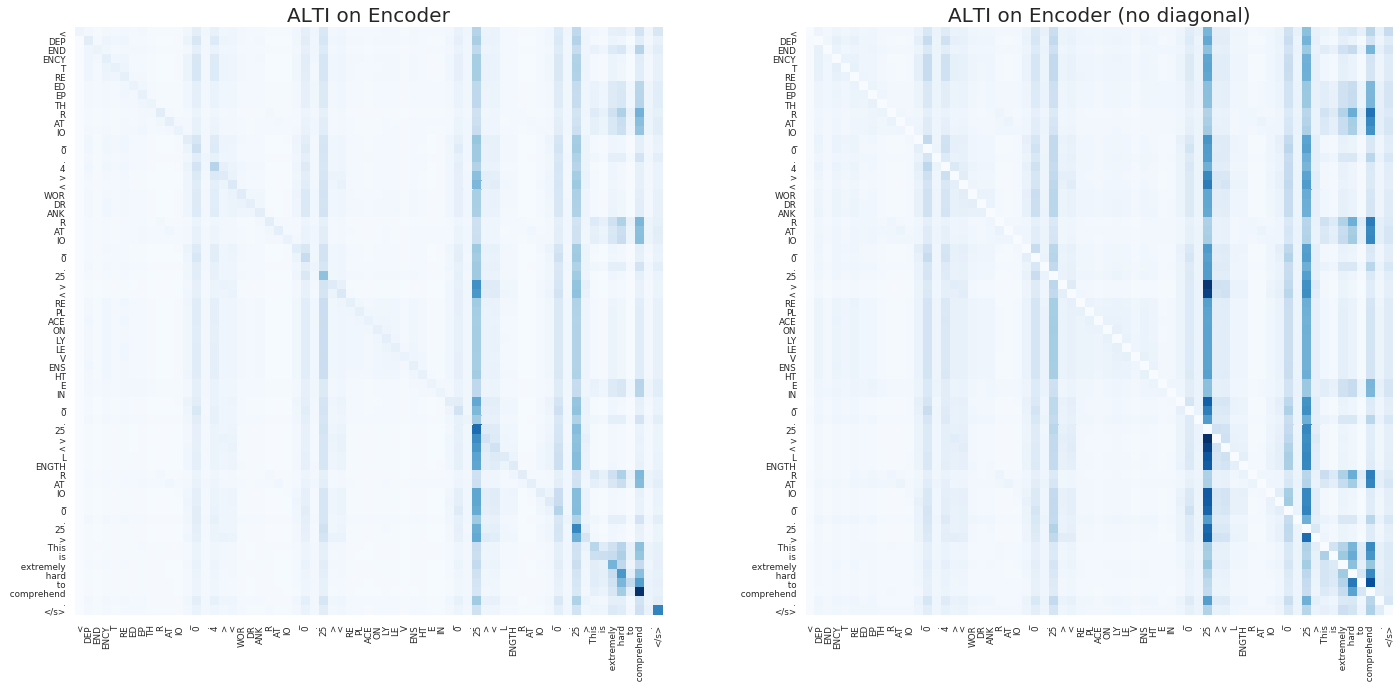

In [19]:
# rollout: 'l1', norm_mode='min_sum'
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                        norm_mode='min_sum', pre_layer_norm=True)['encoder.self_attn']

# relevances_enc_self_attn = relevances
print(len(relevances_enc_self_attn))
layer = len(relevances_enc_self_attn)-1

# Encoder self-attention relevances in last layer (full encoder ALTI)
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.015)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])

relevances_enc_self_attn_last = relevances_enc_self_attn[layer]
relevances_enc_self_attn_last_no_diag = relevances_enc_self_attn_last - torch.diag(relevances_enc_self_attn_last.diag())
# print(relevances_enc_self_attn_last.shape)
df = pd.DataFrame(relevances_enc_self_attn_last.cpu().detach().numpy(), columns=src_tok, index=src_tok)
sns.set(font_scale=1.2)
sns.heatmap(df, cmap="Blues", ax=ax_left, square=True, cbar=False)
ax_left.set_title('ALTI on Encoder', fontsize=20)

df = pd.DataFrame(relevances_enc_self_attn_last_no_diag.cpu().detach().numpy(), columns=src_tok, index=src_tok)
sns.heatmap(df, cmap="Blues", ax=ax_right, square=True, cbar=False)
ax_right.set_title('ALTI on Encoder (no diagonal)', fontsize=20)
plt.gcf().subplots_adjust(bottom=0.2)

Attention weights (raw) in the cross attention at selected layer.
Corresponds to Figure 8-a of the paper

torch.Size([12, 7, 65])
['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', ' <', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', ' <', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', 'V', 'ENS', 'HT', 'E', 'IN', '_', '0', '.', '25', '>', ' <', 'L', 'ENGTH', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', ' This', ' is', ' extremely', ' hard', ' to', ' comprehend', '.', '</s>'] 65
['This', ' is', ' hard', ' to', ' comprehend', '.', '</s>'] 7


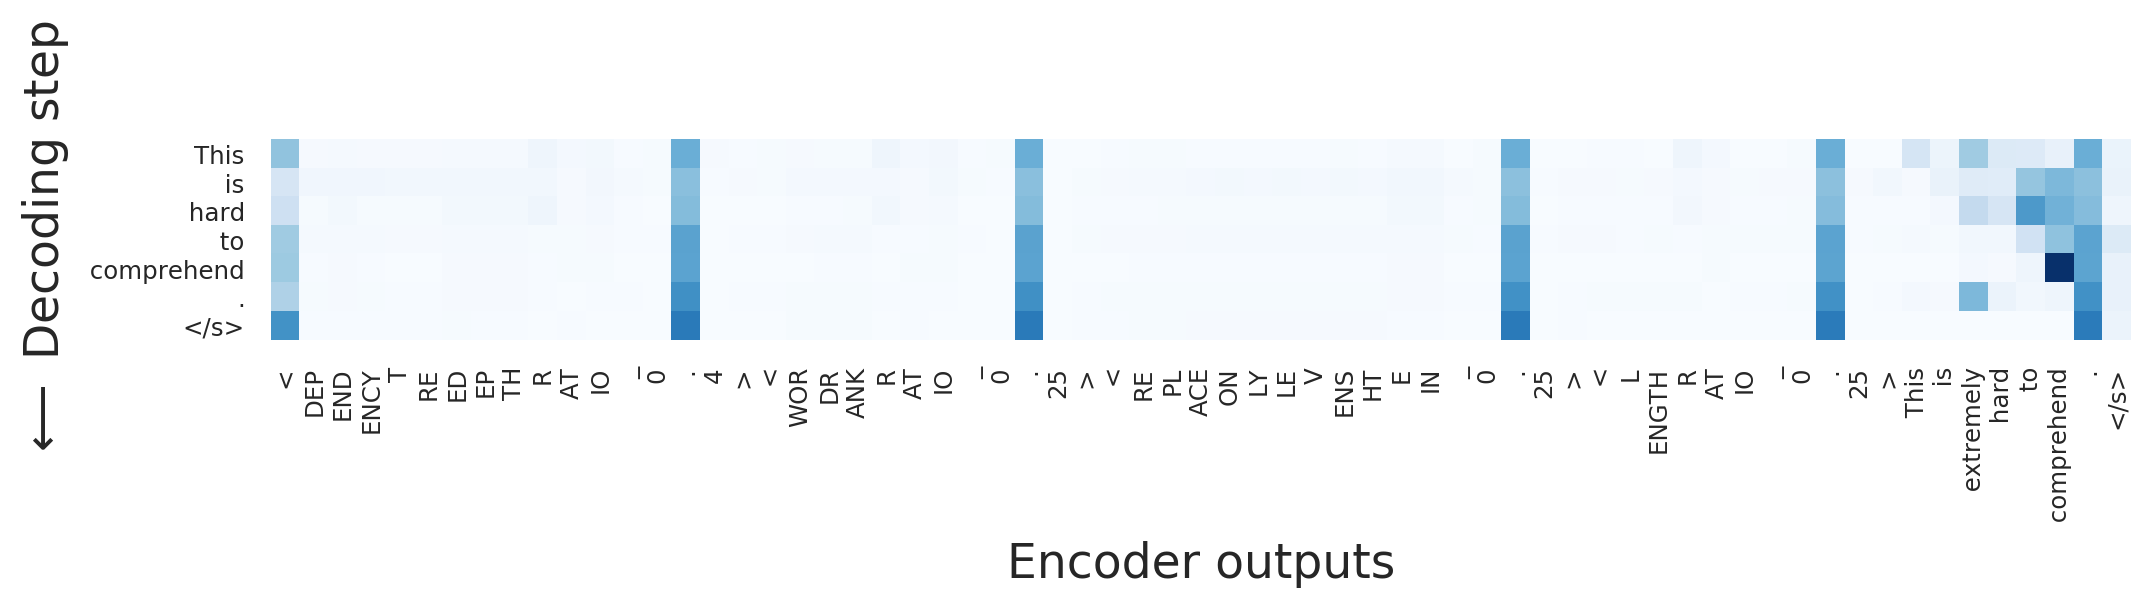

In [31]:
# attn_w, norm_mode='sum_one'
cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w',
                                                                norm_mode='sum_one',pre_layer_norm=True)['decoder.encoder_attn'])

layer = -2
print(cross_attn_contributions.shape)

cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(12,12),dpi=200)


print(src_tok, len(src_tok))
print(pred_tok, len(pred_tok))

df = pd.DataFrame(cross_attn_contributions[layer], columns=src_tok, index=pred_tok)
sns.set(font_scale=0.8)
# df
# s = sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues", square=True, cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False)
# plt.xticks(rotation=60);

Cross-attention contributions $[\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{e}};\mathbf{C}_{\widetilde{\mathbf{y}}\gets\widetilde{\bm{y}}^{s}_{t}}]$ of the encoder outputs $\mathbf{e}$ and residual $\widetilde{\bm y}_{t}^{s}$ to the decoder layer output.

Corresponds to Figure 8-b of the paper.

mean residual 0.86059266 std 0.06683225


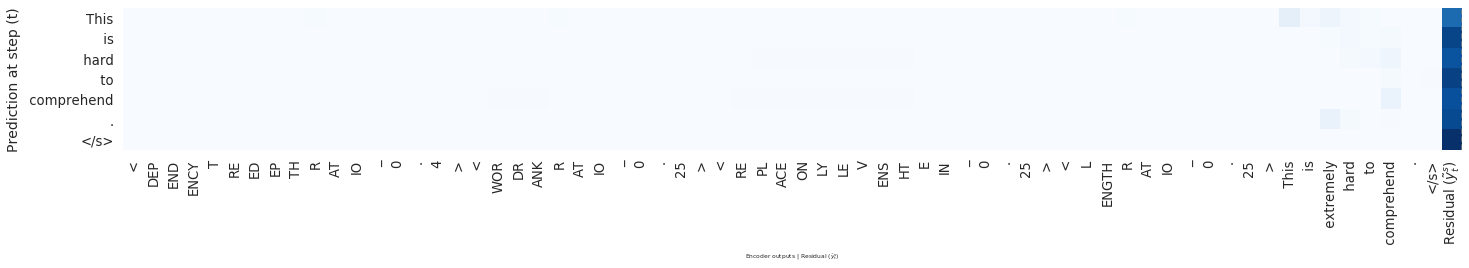

In [35]:
cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor,
                                        tgt_tensor, 'l1', norm_mode='min_sum',
                                        pre_layer_norm=True)['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()

layer = -1
plt.figure(figsize=(24,12))

df = pd.DataFrame(cross_attn_contributions[layer],columns=src_tok + ['Residual'], index=pred_tok)
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=6)
s.set_ylabel('Prediction at step (t)', fontsize=14)

plt.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=src_tok + [r'Residual $(\tilde{y}^{s}_{t})$'])

plt.axvline(x = len(src_tok)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


### ALTI+

ALTI+ for the entire model. Last layer heatmap shows relevances of input tokens to the model prediction: $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{x}}$ | $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{\mathbf{y}_{<t}}}$

In [36]:
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum', pre_layer_norm=True)['total']

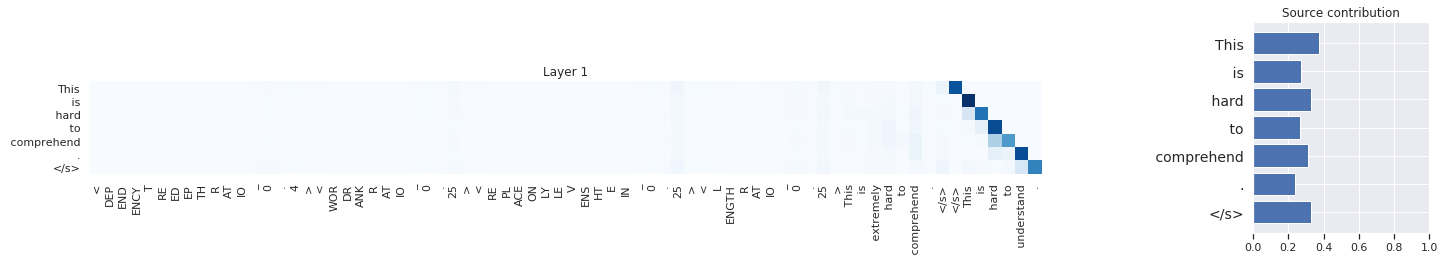

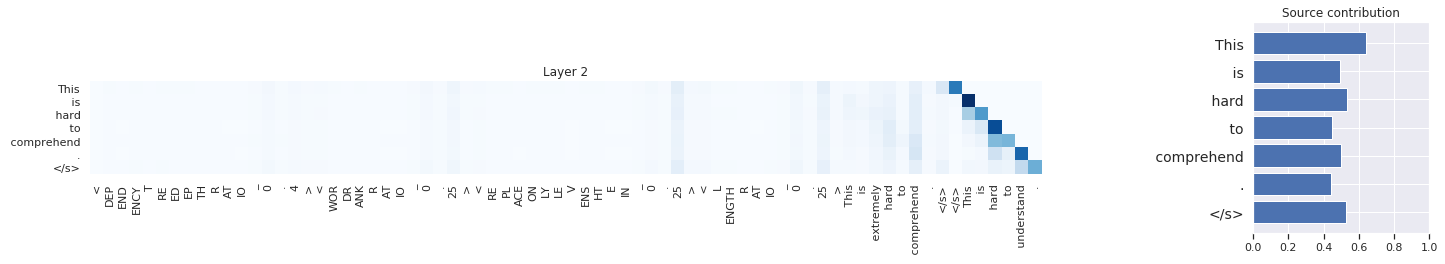

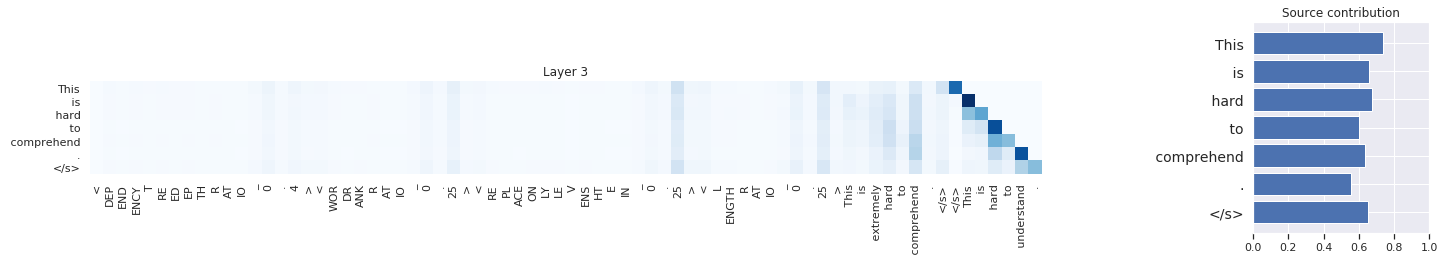

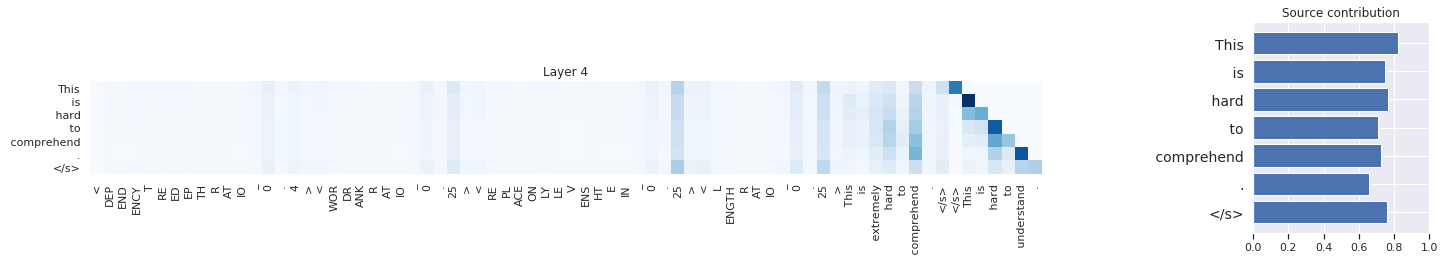

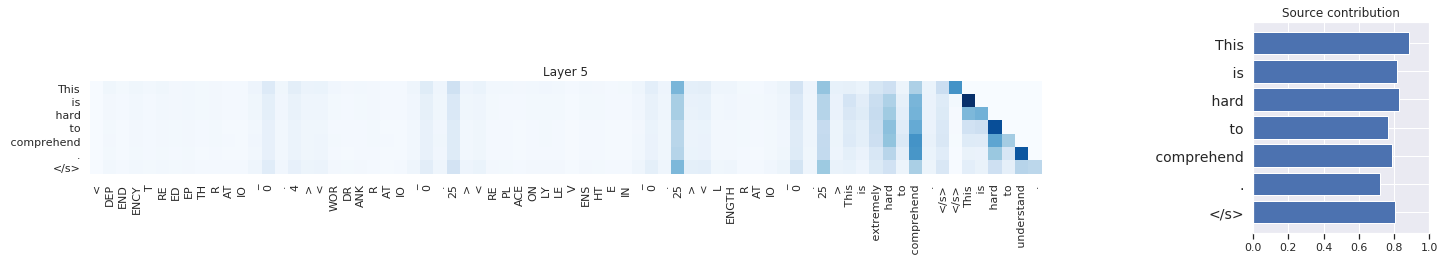

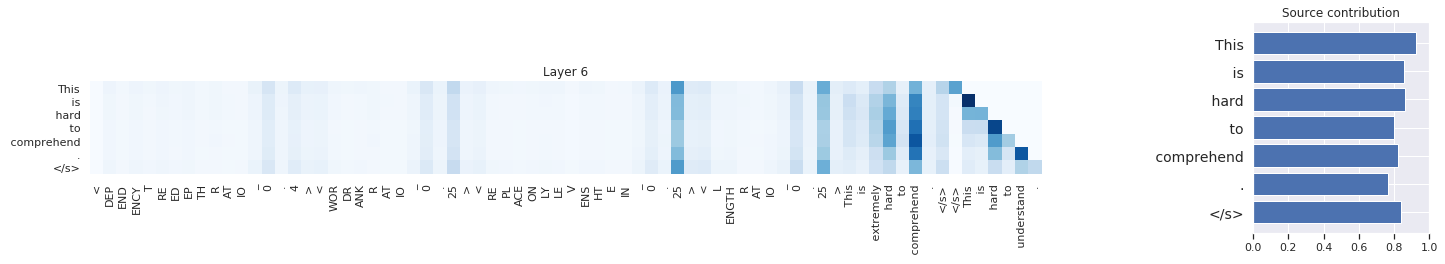

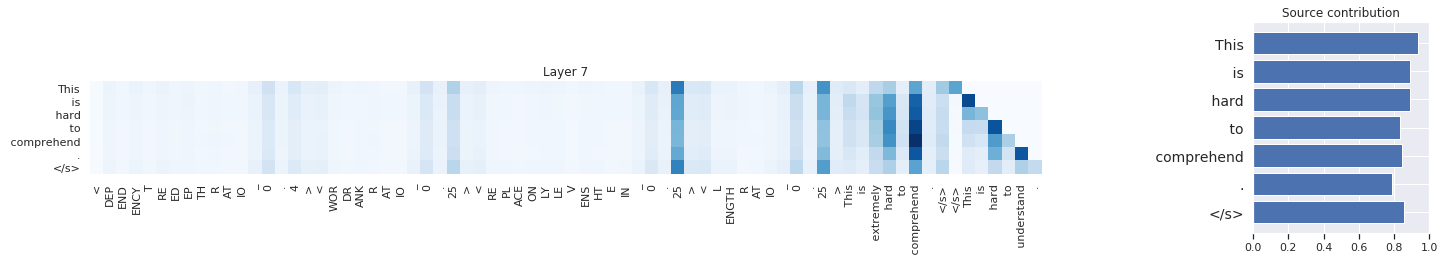

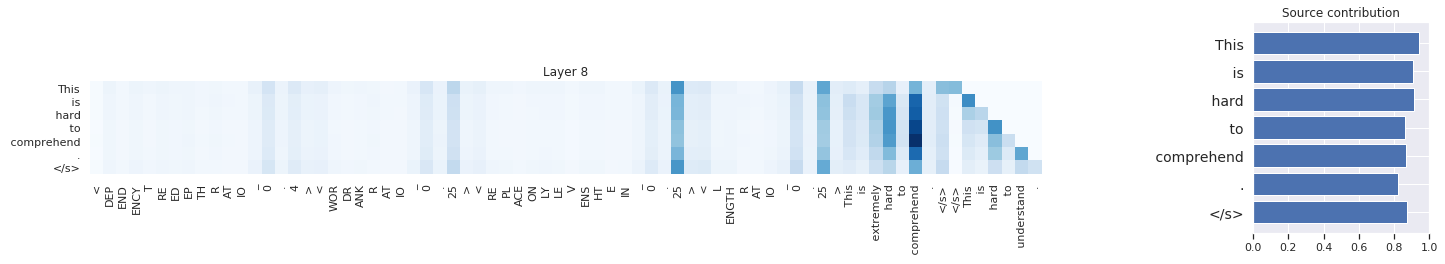

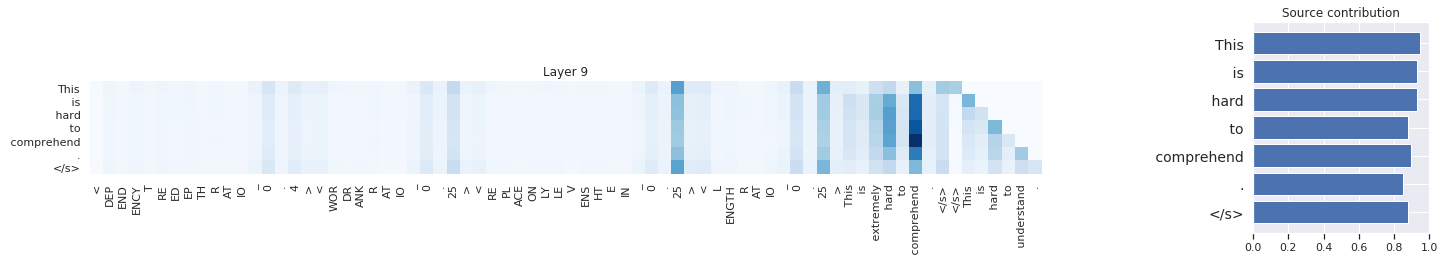

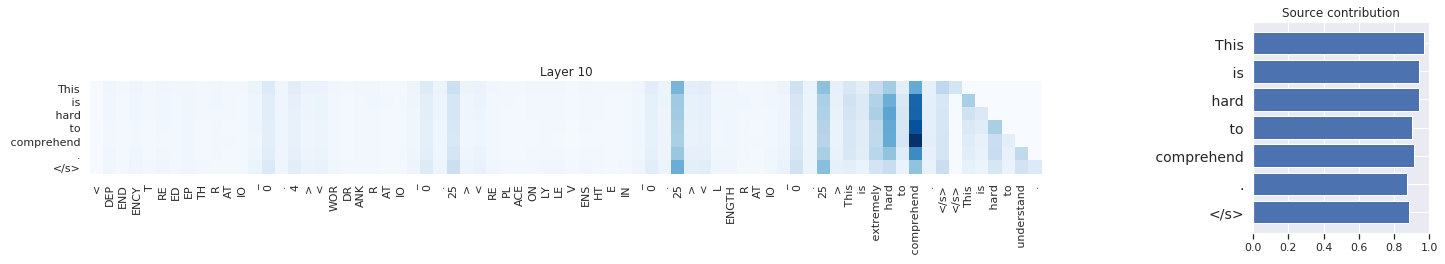

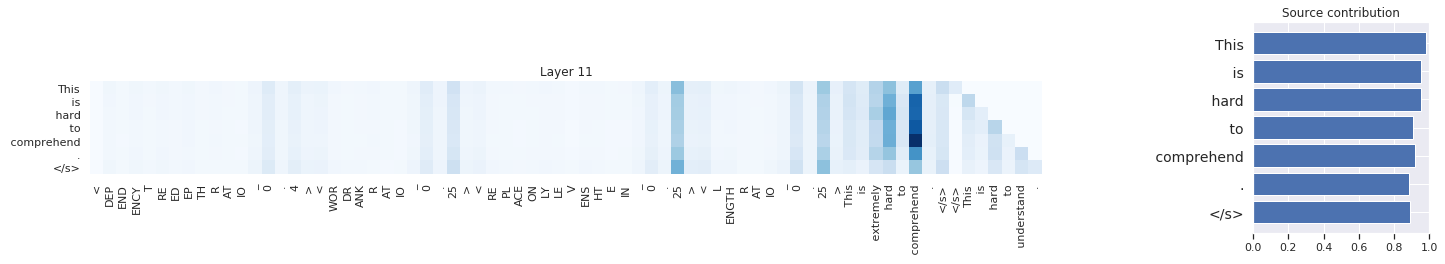

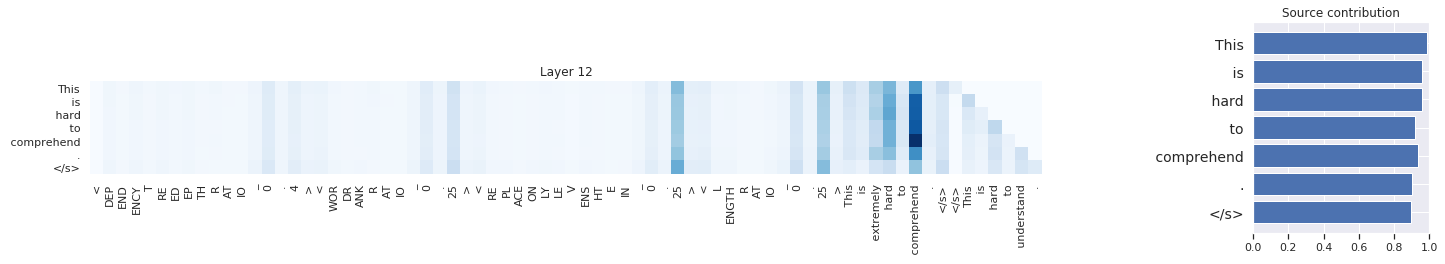

In [84]:
sns.set(font_scale=1.0)
# could plot all on a single figure...
for layer in range(0, total_alti.shape[0]):
    fig = plt.figure(figsize=(24, 12))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_alti[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = src_tok + tgt_tok, index = pred_tok)
    sns.heatmap(df, cmap="Blues", square=True, ax=ax_main, cbar=False) #Reds, center=0
    
    # side plot
    src_contribution = contributions_rollout_layer_np[:, :src_tensor.size(0)].sum(-1)
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = pred_tok)
    #sns.set_style("white")
    ax_yDist.barh(range(0, len(pred_tok)), df_src_contribution.src_contribution, align='center')
#     plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = tgt_tok + ['<EOS>'],fontsize='14')
    plt.yticks(ticks = range(0, len(pred_tok)) ,labels=pred_tok, fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
#     plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig(f'./bart_plots/bart-muss_alti-plus_l{layer}.png')

In [48]:
# print(contributions_rollout_layer_np.shape)
# print(contributions_rollout_layer_np[:, :src_tensor.size(0)].shape)
# print(contributions_rollout_layer_np[:, :src_tensor.size(0)].sum(-1))


(7, 72)
(7, 65)
[0.3728289  0.26881984 0.32647908 0.26495954 0.31183845 0.2370324
 0.32577658]


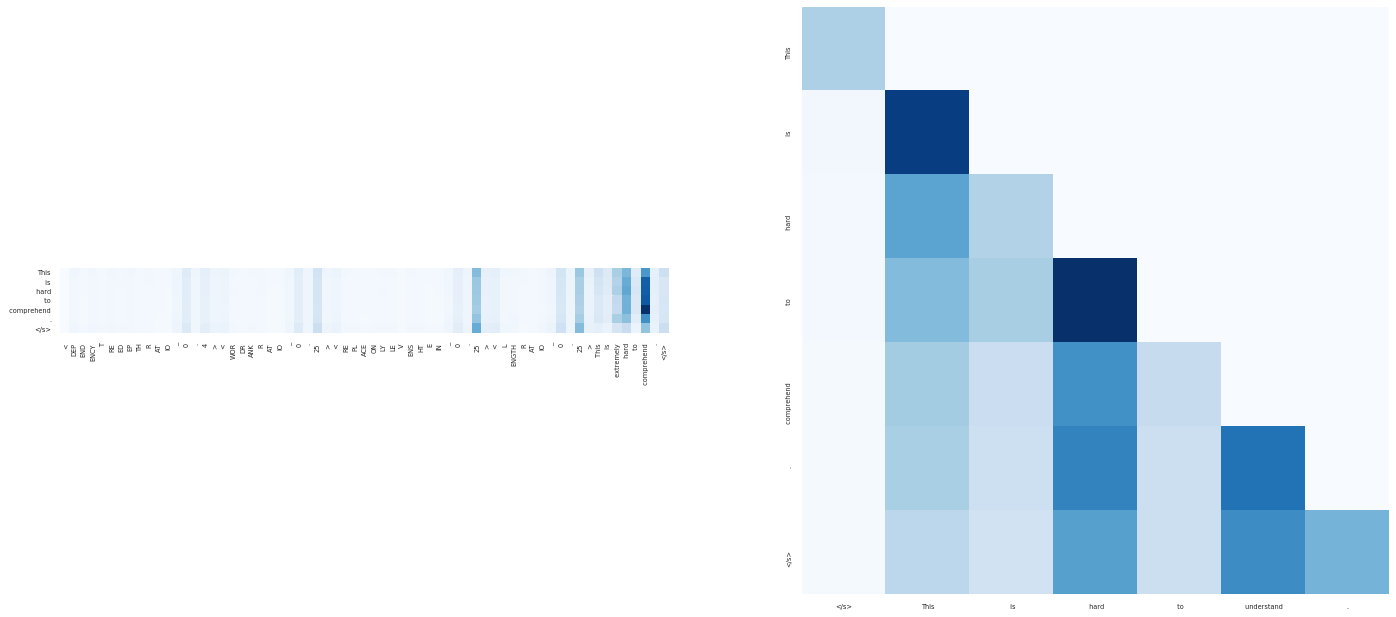

In [74]:
# Separated plots for ALTI+ in last layer
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])

df = pd.DataFrame(contributions_rollout_layer_np[:, :len(src_tok)], columns=src_tok, index=pred_tok)
sns.set(font_scale=0.6)
s = sns.heatmap(df, cmap="Blues", square=True, ax=ax_left, cbar=False)

df = pd.DataFrame(contributions_rollout_layer_np[:,len(src_tok):len(src_tok)+len(tgt_tok)], columns=tgt_tok, index=pred_tok)
s = sns.heatmap(df, cmap="Blues", square=True, ax=ax_right, cbar=False)
plt.gcf().subplots_adjust(bottom=0.2)
# s.set_xlabel('TGT sequence')
# s.set_ylabel('Prediction Timesteps')

# Merging contributions to word-level

In [138]:
def merge_contributions(src_tokens, tgt_tokens, token_contributions):
    
    
    src_words = ''.join(src_tokens[:-1]+ [' </s>']).split()
    tgt_words = ''.join(['</s> '] + tgt_tokens[1:]).split()
    words = src_words + tgt_words
    print(words)
    
    word_i = 0
    word_to_bpe = [[] for _ in range(len(words))]
    print(word_to_bpe)
    for bpe_i, token in enumerate(src_tokens + tgt_tokens):
#         print(token)
        if token == '</s>' or token.startswith("__") or token.startswith(" "):
            word_i += 1
#         print(token, word_i)
        word_to_bpe[word_i-1].append(bpe_i)
    
    words_contrib = []
    for word in word_to_bpe:
        word_contrib_sum = 0
        for subword in word:
            word_contrib_sum += word_bpe_contributions[subword]
        words_contrib.append(word_contrib_sum)
    return words_list, words_contrib

# print(''.join(src_tok), ''.join(tgt_tok))
word_bpe_contributions = list(total_alti[-1][-1].detach().cpu().numpy())
words_list, words_contrib = merge_contributions(src_tok, tgt_tok, word_bpe_contributions)
print(words_list)
print(words_contrib)

['<DEPENDENCYTREEDEPTHRATIO_0.4>', '<WORDRANKRATIO_0.25>', '<REPLACEONLYLEVENSHTEIN_0.25>', '<LENGTHRATIO_0.25>', 'This', 'is', 'extremely', 'hard', 'to', 'comprehend.', '</s>', '</s>', 'This', 'is', 'hard', 'to', 'understand.']
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
['<DEPENDENCYTREEDEPTHRATIO_0.4>', '<WORDRANKRATIO_0.25>', '<REPLACEONLYLEVENSHTEIN_0.25>', '<LENGTHRATIO_0.25>', 'This', 'is', 'extremely', 'hard', 'to', 'comprehend.', '</s>', '</s>', 'This', 'is', 'hard', 'to', 'understand.']
[0.13023195136338472, 0.21250504115596414, 0.19195810751989484, 0.016234977170825005, 0.011473678052425385, 0.02938592992722988, 0.03901110216975212, 0.011155601590871811, 0.07959774229675531, 0.03744107112288475, 0.01345215126639232, 0.008573846891522408, 0.025200407952070236, 0.009804192930459976, 0.050082311034202576, 0, 0.133891916484572]


## Word-word alignments (source-target) from contributions

Currently only works for teacher forcing

In [194]:
src_word_sent = src_sentence
print(src_word_sent)
print(src_tok)
src_tok_str = ' '.join(src_tok[:-1]).replace('  ', ' @@')
print(src_tok_str)

# target_sentence[0] = '</s>▁'#▁__en__'
# print(tgt_tok)
tgt_tok_str = ' '.join(tgt_tok[1:]).replace('  ', ' @@')
tgt_word_sent = tgt_sentence
print(tgt_tok_str)
print(tgt_word_sent)

<DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.25> <REPLACEONLYLEVENSHTEIN_0.25> <LENGTHRATIO_0.25> This is extremely hard to comprehend.
['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', ' <', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', ' <', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', 'V', 'ENS', 'HT', 'E', 'IN', '_', '0', '.', '25', '>', ' <', 'L', 'ENGTH', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', ' This', ' is', ' extremely', ' hard', ' to', ' comprehend', '.', '</s>']
< DEP END ENCY T RE ED EP TH R AT IO _ 0 . 4 > @@< WOR DR ANK R AT IO _ 0 . 25 > @@< RE PL ACE ON LY LE V ENS HT E IN _ 0 . 25 > @@< L ENGTH R AT IO _ 0 . 25 > @@This @@is @@extremely @@hard @@to @@comprehend .
This @@is @@hard @@to @@understand .
This is hard to understand.


In [195]:
tgt_splited_bpe_sent = tgt_word_sent.split()
print(tgt_splited_bpe_sent)
splited_word_sent = tgt_tok_str.split()
print(splited_word_sent)

['This', 'is', 'hard', 'to', 'understand.']
['This', '@@is', '@@hard', '@@to', '@@understand', '.']


In [196]:
contribution_pred_src = contributions_rollout_layer_np[:,:len(src_tok)]#[:,1:] # delete first row
print(contribution_pred_src.shape)

print(src_tok_str.split())
print(src_word_sent.split())

src_word_to_bpe = align.convert_bpe_word(src_tok_str.split(), src_word_sent.split())
print(src_word_to_bpe)

print(tgt_tok_str.split())
print(tgt_word_sent.split())
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str.split(), tgt_word_sent.split())

contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)

contributions_word_word.shape

(7, 65)
['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', '@@<', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', '@@<', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', 'V', 'ENS', 'HT', 'E', 'IN', '_', '0', '.', '25', '>', '@@<', 'L', 'ENGTH', 'R', 'AT', 'IO', '_', '0', '.', '25', '>', '@@This', '@@is', '@@extremely', '@@hard', '@@to', '@@comprehend', '.']
['<DEPENDENCYTREEDEPTHRATIO_0.4>', '<WORDRANKRATIO_0.25>', '<REPLACEONLYLEVENSHTEIN_0.25>', '<LENGTHRATIO_0.25>', 'This', 'is', 'extremely', 'hard', 'to', 'comprehend.']
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], [57], [58], [59], [60], [61], [62, 63], [64]]
['This', '@@is', '@@hard', '@@to', '@@understand', '.']
['This', 'is', 'hard', 'to', 'understand.']


(6, 11)

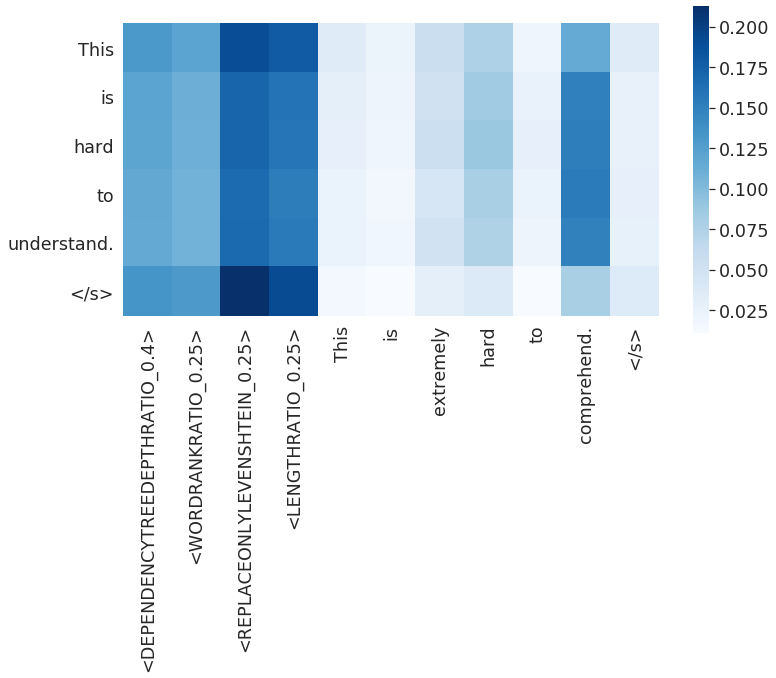

In [197]:
## Soft alignment
plt.figure(figsize=(12,6))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

[2 2 2 2 2 2]


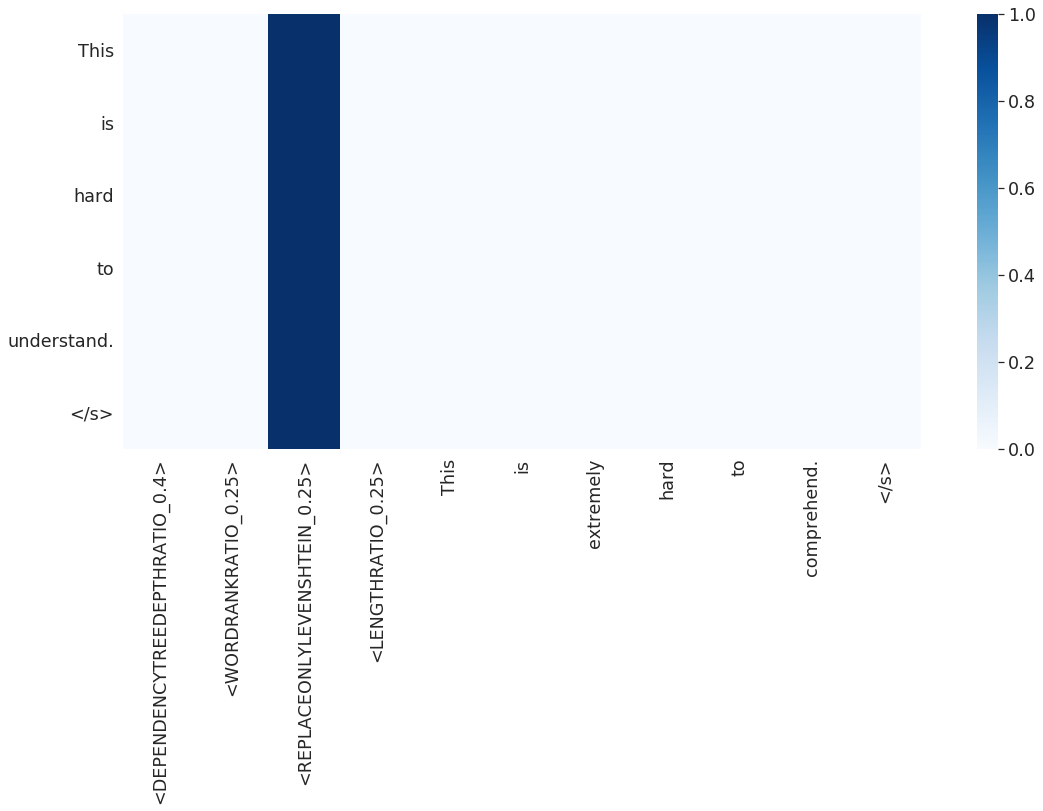

In [190]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
print(a_argmax)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);